In [2]:
from helper import *    
import seaborn as sns
import os
import struct
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import ast

EXTRACT FILES FROM FOLDER

In [170]:
datasetsFolderPath = './datasets/'
radarFilePath = os.path.join(datasetsFolderPath,"radar_data")
depthFilePath = os.path.join(datasetsFolderPath,"depth_data")
# filtered_file = sorted([content for content in os.listdir(folder_path) if content.startswith("drone")])
filteredBinFile = [f for f in os.listdir(radarFilePath) if os.path.isfile(os.path.join(radarFilePath, f)) and f.endswith('.bin') and not f.startswith('only_sensor')]
filteredCsvFile = [f for f in os.listdir(depthFilePath) if os.path.isfile(os.path.join(depthFilePath, f)) and f.endswith('.csv') and not f.startswith('only_sensor')]

# List all the contents of the folder
for file in filteredCsvFile:
    print(file)
for file in filteredBinFile:
    print(file)


drone_2024-09-10_10_05_34_test_depth.csv
drone_2024-09-10_11_11_13_test_depth.csv
drone_2024-09-10_12_02_19_test_depth.csv
drone_2024-09-10_16_12_18_test_depth.csv
drone_2024-09-10_11_11_13_test.bin
drone_2024-09-10_12_02_19_test.bin
drone_2024-09-10_16_12_18_test.bin


In [146]:
lidarDf = pd.read_csv("./datasets/lidar_data/drone_2024-09-10_16_12_18_test_lidar.csv")
depthDf = pd.read_csv("./datasets/depth_data/drone_2024-09-10_12_02_19_test_depth.csv")

PCD ANALYSE

In [3]:
def point_cloud_frames(file_name = None):
    info_dict = get_info(file_name)
    run_data_read_only_sensor(info_dict)
    bin_filename = './datasets/radar_data/only_sensor_' + info_dict['filename'][0]
    bin_reader = RawDataReader(bin_filename)
    total_frame_number = int(info_dict[' Nf'][0])
    pointCloudProcessCFG = PointCloudProcessCFG()
    velocities = []
    pcds = []
    start_time = file_name.split('/')[-1].split('.')[0].split('drone_')[-1][:19]
    start_time_obj = datetime.strptime(start_time,'%Y-%m-%d_%H_%M_%S')
    time_frames = []
    for frame_no in range(total_frame_number):
        time_current = start_time_obj+timedelta(seconds=frame_no*(info_dict["periodicity"][0])/1000)
        time_frames.append(time_current.strftime('%Y-%m-%d %H_%M_%S.%f'))
        bin_frame = bin_reader.getNextFrame(pointCloudProcessCFG.frameConfig)
        np_frame = bin2np_frame(bin_frame)
        frameConfig = pointCloudProcessCFG.frameConfig
        reshapedFrame = frameReshape(np_frame, frameConfig)
        rangeResult = rangeFFT(reshapedFrame, frameConfig)
        if frame_no == 5:
            range_heatmap = np.sum(np.abs(rangeResult), axis=(0,1))
            # print("range_heatmap.shape: ", range_heatmap.shape)
            # sns.heatmap(range_heatmap)
            # plt.savefig('range.png')
        
        dopplerResult = dopplerFFT(rangeResult, frameConfig)
        pointCloud = frame2pointcloud(dopplerResult, pointCloudProcessCFG)
        pcds.append(pointCloud)
    return pcds, time_frames

CALLL PREVIOUS FUNC AND EXTRACT PCDS

In [5]:
gen, timestamps =point_cloud_frames(file_name ="./datasets/radar_data/drone_2024-09-10_16_12_18_test.bin")

total_data = []
total_ids = []
total_frames=0
first_frame = True
initial_coordinates = {}
current_cluster = {}
points = []
total_frameStacked = []
prev_point = np.array([0,0])
timestamps
for pointcloud in gen:
    total_frameStacked.append(pointcloud[:,:3])#sliced 1st 3 as x y z
    # print(pointcloud.shape)
    # print(type(pointcloud))
    # break
    
stacked = np.stack(total_frameStacked)

print(stacked.shape) 


(20, 1000, 3)


DATAFRAME AND PCS MERGE


In [6]:
df = pd.DataFrame()
df["datetime"] = timestamps
df["pcd"] = total_frameStacked
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H_%M_%S.%f')
df.head(5)

,datetime,pcd
0,2024-09-10 16:12:18.000,"[[0.102030374, 0.80773413, 0.058377866], [3.43..."
1,2024-09-10 16:12:18.200,"[[2.2366133, 3.442574, 0.9333541], [2.259436, ..."
2,2024-09-10 16:12:18.400,"[[-1.9023294, 4.066605, 1.3308431], [1.8687669..."
3,2024-09-10 16:12:18.600,"[[0.0, 0.2501847, 0.1668556], [2.9333732, 3.92..."
4,2024-09-10 16:12:18.800,"[[0.0, 1.456588, 0.63635176], [3.4394977, 3.93..."


In [7]:
df["pcd"][0][:,2]

array([ 5.8377866e-02, -4.6388695e-01,  1.7244066e-01,  1.3975257e-01,
       -7.3066726e-02, -2.9128535e+00,  1.9950120e+00,  4.7204976e+00,
       -2.0243154e-01,  6.6057760e-01,  9.1126633e-01,  4.3737948e-01,
        4.7646255e+00,  6.3377374e-01,  1.9016925e-01,  3.8817942e+00,
        4.1676041e-01,  1.4771794e-01, -0.0000000e+00,  4.9931641e+00,
        4.8101950e+00, -3.8306046e-02,  3.8367970e+00, -6.8612182e-01,
       -4.2750004e-01, -4.6323221e-03,  9.1491383e-01, -1.1534353e+00,
        7.4687171e-01,  5.3442679e-02, -2.9128535e+00, -2.7327111e-01,
        8.8442034e-01,  3.8817942e+00,  8.5068381e-01, -1.1343750e+00,
        1.9950120e+00, -9.4626788e-03,  1.1303325e+00, -2.1255144e-01,
        2.1769686e+00, -4.8427553e+00, -1.6895263e+00,  1.4968060e+00,
        3.7982568e-01,  2.6422584e-01, -3.4330365e-01,  3.7982568e-01,
        2.3952422e-01, -1.6801915e+00, -3.7640700e-01,  8.8442034e-01,
        7.4903268e-01,  8.7844491e-02,  2.6220128e-01, -0.0000000e+00,
      

In [8]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111,projection='3d')
# lisx = ast.literal_eval(pcd["x"])
# lisy = ast.literal_eval(row["y"])
# lisz = ast.literal_eval(row["z"])
# print(li[0])
img = ax.scatter(df["pcd"][0][:,0], df["pcd"][0][:,1],df["pcd"][0][:,2], cmap="viridis",marker='o')
fig.colorbar(img)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.savefig("radar.png")
# plt.show()
plt.close()

In [141]:
depthDf = depthDf.iloc[:20]#after 20 frames NaT was coming
depthDf.head(5)

,datetime,frame_number,x,y,z
0,2024-09-10 16:12:18.000,3,[-1.7279944 -1.7226362 -1.7267772 ... 0.43...,[-1.2578931 -1.2578931 -1.2648512 ... 0.33...,[3.2540002 3.2540002 3.272 ... 0.832 ...
1,2024-09-10 16:12:18.200,4,[-1.737553 -1.7321652 -1.735749 ... 0.42...,[-1.2648512 -1.2648512 -1.271423 ... 0.33...,[3.272 3.272 3.2890003 ... 0.827 ...
2,2024-09-10 16:12:18.400,6,[-1.7465807 -1.7411649 -1.7452483 ... 0.42...,[-1.271423 -1.271423 -1.2783811 ... 0.33...,[3.2890003 3.2890003 3.3070002 ... 0.827 ...
3,2024-09-10 16:12:18.600,7,[-1.7465807 -1.7411649 -1.735749 ... 0.42...,[-1.271423 -1.271423 -1.271423 ... 0.33...,[3.2890003 3.2890003 3.2890003 ... 0.828000...
4,2024-09-10 16:12:18.800,8,[-1.7465807 -1.7411649 -1.735749 ... 0.43...,[-1.271423 -1.271423 -1.271423 ... 0.33...,[3.2890003 3.2890003 3.2890003 ... 0.831000...


In [219]:
depthDf = pd.read_csv("depth.csv")

In [224]:
depthDf["depthPCD"][0]
lisx = ast.literal_eval(depthDf["depthPCD"][0])


In [230]:
pcda = np.array(lisx)

In [233]:
pcda[:,0]
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111,projection='3d')
# lisx = ast.literal_eval(pcd["x"])
# lisy = ast.literal_eval(row["y"])
# lisz = ast.literal_eval(row["z"])
# print(li[0])
img = ax.scatter(pcda[:,0], pcda[:,1],pcda[:,2], cmap="viridis",marker='o')
fig.colorbar(img)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.savefig("depth.png")
# plt.show()
plt.close()

In [150]:
# df.merge(lidarDf,on='datetime',)
mergerdPcdDepth = pd.merge_asof(df, depthDf, on='datetime',tolerance=pd.Timedelta('2us'), direction='nearest')
print(mergerdPcdDepth.shape)
mergerdPcdDepth.head(5)

MergeError: Incompatible merge dtype, dtype('O') and dtype('<M8[ns]'), both sides must have numeric dtype

In [115]:
print(type(df['datetime']))
print(type(depthDf['datetime']))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [113]:
print(lidarDf.columns)
print(depthDf.columns)
print(df.columns)

Index(['datetime', '0', '1', '2', '3', '4', '5', '6', '7', '8',
       ...
       '350', '351', '352', '353', '354', '355', '356', '357', '358', '359'],
      dtype='object', length=361)
Index(['datetime', 'frame_number', 'x', 'y', 'z'], dtype='object')
Index(['datetime', 'pcd'], dtype='object')


In [142]:
# depthDf.head(30)

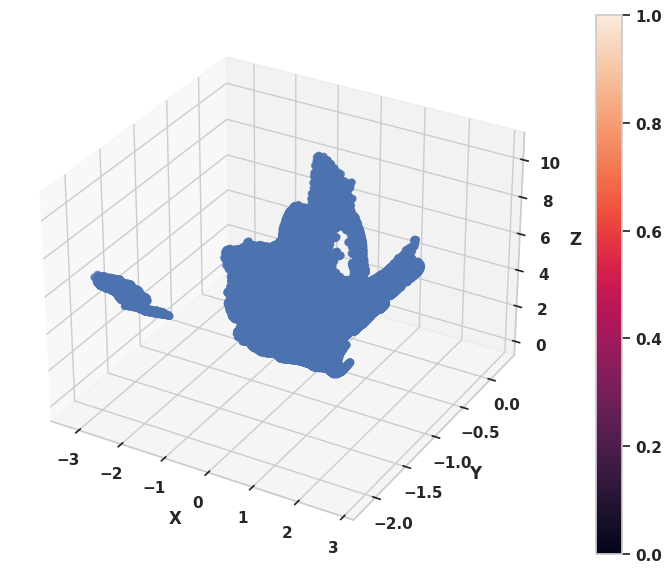

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

<Figure size 1000x700 with 0 Axes>

In [82]:
sns.set(style="whitegrid")
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot(111,projection='3d')
for index,row in depthDf.iterrows():
    i=0
    lisx = ast.literal_eval(row["x"])
    lisy = ast.literal_eval(row["y"])
    lisz = ast.literal_eval(row["z"])
    # print(li[0])
    img = ax.scatter(lisx, lisy,lisz, cmap="viridis",marker='o')
    fig.colorbar(img)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.savefig("depth.png")
    # plt.show()
    plt.close()
    # break




In [94]:
dt_obj = datetime.strptime(depthDf['datetime'][0], '%Y-%m-%d %H:%M:%S.%f')
dt_obj.strftime('%Y-%m-%d %H_%M_%S.%f')

'2024-09-10 12_02_25.002278'

In [7]:
depthDf['datetime'][0] = str(dt_obj.date()) + " " + str(dt_obj.strftime('%H:%M:%S'))

/home/tirthapc/anaconda3/envs/mmenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
date_only = dt_obj.date()

# Extract only the time up to seconds
time_only = dt_obj.strftime('%H:%M:%S')

print(f"Date: {date_only}")
print(f"Time: {time_only}")

Date: 2024-09-10
Time: 16:12:23


In [9]:
depthDf["z"][0]

'[4.868 4.868 4.829 ... 0.386 0.386 0.386]'

In [38]:
for index,row in depthDf.iterrows():
    i=0
    # for i in range(len(row["x"])):
        # print(row["x"][i],row["y"][i],row["z"][i])
    print(type(row["x"]))
    break


# fig = plt.figure(figsize=(12,7))
# ax = fig.add_subplot(projection='3d')
# img = ax.scatter(lidarDf["x"], lidarDf["y"], lidarDf["z"], cmap=plt.hot())
# fig.colorbar(img)
# ax.set_xlabel('X')
# ax.set_ylabel('Y')
# ax.set_zlabel('Z')

<class 'str'>


IMU Process


In [4]:
imu_data = "./datasets/imu_data/drone_2024-09-10_16_12_18_test_imu.bin"
with open(imu_data, 'rb') as file:
    while True:
        binary_data = file.read(56)
        if len(binary_data) < 56:
            break
        unpacked_data = struct.unpack('d' * 7, binary_data)

        timestamp = unpacked_data[0]
        imu_data = unpacked_data[1:]

        print("Timestamp:", timestamp)
        print("IMU Data:", imu_data)


Timestamp: 1725964953.401418
IMU Data: (0.19632453613281248, 0.22026655273437498, -4.955997436523437, -0.001732006127933304, 0.01052526800821008, -0.021849923460081685)
Timestamp: 1725964953.441548
IMU Data: (0.12689268798828124, 0.086191259765625, -5.066130712890625, 0.009059724361497283, 0.003863705977697371, -0.01971822361031762)
Timestamp: 1725964953.4886694
IMU Data: (0.21068974609375, 0.02154781494140625, -5.236119030761718, -0.04449923436382489, 0.003863705977697371, -0.024114854550456002)
Timestamp: 1725964953.5270042
IMU Data: (0.143652099609375, 0.15322890625, -4.994304663085937, -0.0035972434964768626, 0.007860643196004996, -0.019052067407266345)
Timestamp: 1725964953.562471
IMU Data: (0.24899697265624998, 0.0143652099609375, -5.123591552734375, -0.000799387443661525, 0.0095926493239383, -0.023315467106794475)
Timestamp: 1725964953.5998313
IMU Data: (0.3064578125, 0.040701428222656245, -5.204994409179688, -0.02904441045303541, -0.0009326186842717792, -0.021849923460081685)
T

In [21]:

timestamp = unpacked_data[0]
imu_data = unpacked_data[1:]

print("Timestamp:", timestamp)
print("IMU Data:", imu_data)


Timestamp: 1725964953.401418
IMU Data: (0.19632453613281248, 0.22026655273437498, -4.955997436523437, -0.001732006127933304, 0.01052526800821008, -0.021849923460081685)


In [1]:
imu_dataTime = "./datasets/time_stamps/time_drone_2024-09-10_16_12_18_test.bin"
with open(imu_dataTime, 'rb') as file:
    while True:
        binary_data = file.read(56)
        if len(binary_data) < 56:
            break
        unpacked_data = struct.unpack('d' * 7, binary_data)

        timestamp = unpacked_data[0]

        print("Timestamp:", timestamp)


NameError: name 'struct' is not defined